<a href="https://colab.research.google.com/github/ychengbf/ECON441B/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("TSLA", start="2011-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################

# look back period: used as input feature(%change) for a single sample to predict the future % change by RNN 
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0]) 
    # extracts the previous input_size percentage changes from the train_data array and appends them to x_train as a new row.
    # The 0 in the second dimension means "select the first (and only) column".
    # creates a matrix where each row represents a sample and each column represents a feature.
    y_train.append(1 if train_data[i, 0] > 0 else 0) 
    # extracts the percentage change for the current time step from the train_data array and appends it to y_train
    # Create the target value of a single sample
                                    
x_train, y_train = np.array(x_train), np.array(y_train)
# Add a third dimension to the x_train(samples, time steps, features)
# samples corresponds to the number of training examples
# time steps corresponds to the number of previous time steps used as input features (i.e., input_size)
# features corresponds to the number of input features at each time step (i.e., 1, since we are using the percentage change in the stock price as the only input feature).
# format required by the LSTM layer in Keras, which is commonly used for time series prediction.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################

model = Sequential()

# adds an LSTM layer to the model.
# The layer has a number of units equal to the number of previous time steps used as input features for each sample (x_train.shape[1]).
# return_sequences=True: return the full sequence of output values for each input sequence. 
# input_shape=(x_train.shape[1], 1):specify the shape of the input data.
model.add(LSTM(x_train.shape[1], activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], 1)))

# adds a second LSTM layer to the model that has 50 units
# return_sequences=False: return only the last output value for each input sequence.
model.add(LSTM(50, activation='tanh', return_sequences=False))

# adds a fully connected Dense layer that has 25 units to the model.
model.add(Dense(25, activation='relu'))

# adds a Dropout layer to the model to drop out a fraction of the input units during training to prevent overfitting
model.add(Dropout(0.5))

model.add(Dense(5, activation='relu')) 

# adds a final Dense layer to the model
# This layer is used for binary classification
# predicted output is a value between 0 and 1 indicating the probability of a certain class (stock price will increase or decrease).
model.add(Dense(1, activation='sigmoid'))

#model.compile(optimizer='adam', loss='mean_squared_error')
#model.fit(x_train, y_train, batch_size=1, epochs=3)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2236/2236 [==============================] - 19s 7ms/step - loss: 0.6940
Epoch 2/3
2236/2236 [==============================] - 15s 7ms/step - loss: 0.6935
Epoch 3/3
2236/2236 [==============================] - 15s 7ms/step - loss: 0.6932


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

70/70 [==============================] - 0s 4ms/step


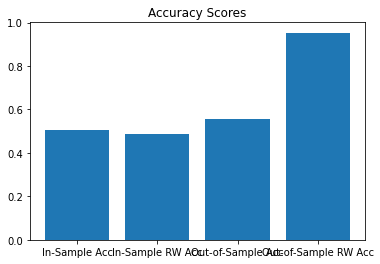

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error

test_data = scaled_data[training_data_len - input_size:, :]
x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the test data
y_pred = model.predict(x_test)

# Convert the predicted probabilities to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate in-sample accuracy
y_train_pred = model.predict(x_train)
y_train_pred_binary = np.where(y_train_pred > 0.5, 1, 0)
in_sample_acc = accuracy_score(y_train_pred_binary, np.where(y_train > 0, 1, 0))

# Calculate in-sample random walk assumption accuracy
y_train_rw = np.roll(y_train, 1)
y_train_rw[0] = 0
in_sample_rw_acc = accuracy_score(y_train, y_train_rw)

# Calculate out-of-sample accuracy
out_sample_acc = accuracy_score(y_pred_binary, np.where(y_test > 0, 1, 0))

# Calculate out-of-sample random walk assumption accuracy
y_test_rw = np.roll(y_test, 1)
y_test_rw[0] = 0
out_sample_rw_acc = 1 - mean_absolute_error(y_test, y_test_rw)

# Plot the results in a bar chart
labels = ['In-Sample Acc', 'In-Sample RW Acc', 'Out-of-Sample Acc', 'Out-of-Sample RW Acc']
scores = [in_sample_acc, in_sample_rw_acc, out_sample_acc, out_sample_rw_acc]
plt.bar(labels, scores)
plt.title('Accuracy Scores')
plt.show()

# 4.) Plot in and out of sample accuracy

18/18 [==============================] - 0s 4ms/step


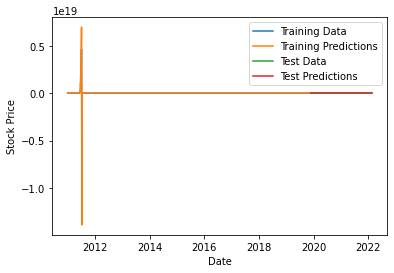

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)


plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In [1]:
# the in sample accuracy and out of sample accuracy is around 0.5 
# the model is not able to capture the patterns in the data and is not providing accurate predictions.
# It could be the reason that the data is inherently noisy or unpredictable
# or The model is overfitting or underfitting the data

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
def create_model(neurons=10, time_lag=5):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_lag, 1), activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'time_lag': [5, 10, 20],
              'neurons': [5, 10, 20],
              'epochs': [10, 50],
              'batch_size': [10, 20]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-23-1174c08fd61c>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.

Best: -0.692831 using {'batch_size': 20, 'epochs': 50, 'neurons': 5, 'time_lag': 5}
